In [59]:
import pandas as pd
import glob
import os

path = "./"

all_files = glob.glob(os.path.join(path, "*.csv"))

dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df = df.drop(columns=["Код поста", "Условный знак"], errors="ignore")

    reservoir_name = os.path.splitext(os.path.basename(file))[0]

    df = df.rename(columns={"Значение": f"Value {reservoir_name}"})

    dfs.append(df)

final_df = dfs[0]
for df in dfs[1:]:
    final_df = pd.merge(final_df, df, on="Дата", how="outer")

final_df= final_df.rename(columns={"Дата": "Date"})
final_df.to_csv("water.csv", index=False, encoding="utf-8-sig")

In [60]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [61]:
DATA_PATH = 'water.csv'
TARGET_COL = 'Value balhash-alakol'
RANDOM_STATE = 42

In [62]:
splits = [(0.60,0.40), (0.70,0.30), (0.75,0.25), (0.80,0.20), (0.85,0.15)]

In [63]:
df = pd.read_csv(DATA_PATH)

In [64]:
if 'Date' in df.columns:
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
  df['year'] = df['Date'].dt.year
  df['month'] = df['Date'].dt.month
  df['day'] = df['Date'].dt.day

for c in df.columns:
  if c != 'Date':
    df[c] = pd.to_numeric(df[c], errors='coerce')

In [65]:
num_cols = [c for c in df.columns if c not in ['Date', TARGET_COL] and pd.api.types.is_numeric_dtype(df[c])]

for c in num_cols + [TARGET_COL]:
  if c in df.columns:
    df[c] = df[c].fillna(df[c].median())


X = df[num_cols]
y = df[TARGET_COL]

In [66]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [67]:
algs = {
  'Decision Tree': DecisionTreeRegressor(random_state=RANDOM_STATE),
  'Random Forest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
  'KNN': KNeighborsRegressor(n_neighbors=5)
}

In [68]:
results = []

for i, (train_frac, test_frac) in enumerate(splits, start=1):
  X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, train_size=train_frac, random_state=RANDOM_STATE)
  for name, model in algs.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)
    results.append({
      'Algorithm': name,
      'Iteration': i,
      'Num_features': X.shape[1],
      'Train_size_%': int(train_frac*100),
      'Test_size_%': int(test_frac*100),
      'RMSE': rmse,
      'R2': r2
    })

In [69]:
from sklearn.neural_network import MLPRegressor

for i, (train_frac, test_frac) in enumerate(splits, start=1):
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_scaled, y, train_size=train_frac, random_state=RANDOM_STATE
    )

    rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(X_train, Y_train)

    residuals = Y_train - rf.predict(X_train)

    nn = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    nn.fit(X_train, residuals)

    Y_pred_hybrid = rf.predict(X_test) + nn.predict(X_test)

    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_hybrid))
    r2 = r2_score(Y_test, Y_pred_hybrid)

    results.append({
        'Algorithm': 'Hybrid RF+NN',
        'Iteration': i,
        'Num_features': X.shape[1],
        'Train_size_%': int(train_frac * 100),
        'Test_size_%': int(test_frac * 100),
        'RMSE': rmse,
        'R2': r2
    })

In [70]:
results_df = pd.DataFrame(results)
print(results_df)

        Algorithm  Iteration  Num_features  Train_size_%  Test_size_%  \
0   Decision Tree          1             9            60           40   
1   Random Forest          1             9            60           40   
2             KNN          1             9            60           40   
3   Decision Tree          2             9            70           30   
4   Random Forest          2             9            70           30   
5             KNN          2             9            70           30   
6   Decision Tree          3             9            75           25   
7   Random Forest          3             9            75           25   
8             KNN          3             9            75           25   
9   Decision Tree          4             9            80           20   
10  Random Forest          4             9            80           20   
11            KNN          4             9            80           20   
12  Decision Tree          5             9         

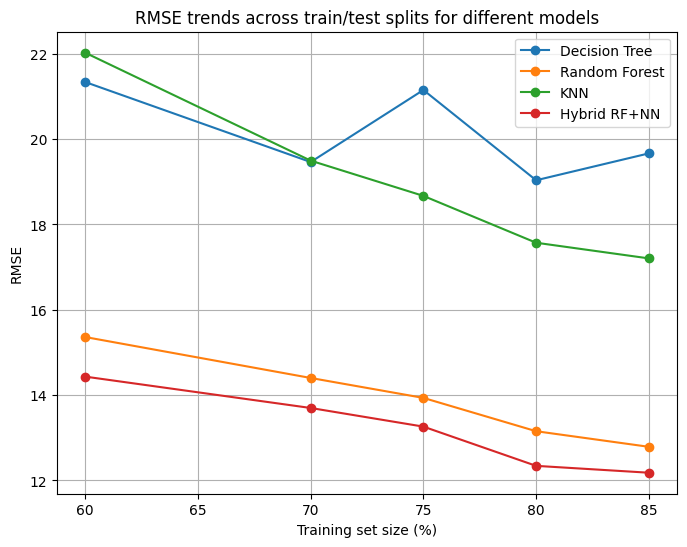

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

plt.figure(figsize=(8, 6))
for alg in results_df["Algorithm"].unique():
    subset = results_df[results_df["Algorithm"] == alg]
    plt.plot(subset["Train_size_%"], subset["RMSE"], marker="o", label=alg)

plt.xlabel("Training set size (%)")
plt.ylabel("RMSE")
plt.title("RMSE trends across train/test splits for different models")
plt.legend()
plt.grid(True)
plt.show()

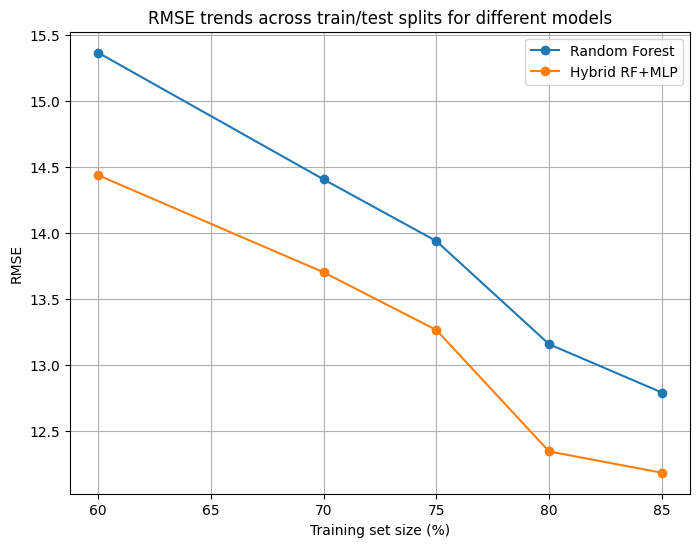

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

plt.figure(figsize=(8, 6))

subset = results_df[results_df["Algorithm"] == "Random Forest"]
plt.plot(subset["Train_size_%"], subset["RMSE"], marker="o", label="Random Forest")
subset = results_df[results_df["Algorithm"] == "Hybrid RF+NN"]
plt.plot(subset["Train_size_%"], subset["RMSE"], marker="o", label="Hybrid RF+MLP")

plt.xlabel("Training set size (%)")
plt.ylabel("RMSE")
plt.title("RMSE trends across train/test splits for different models")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-1795393174.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Iteration", y="Residual", data=residuals_df, palette="Set2")


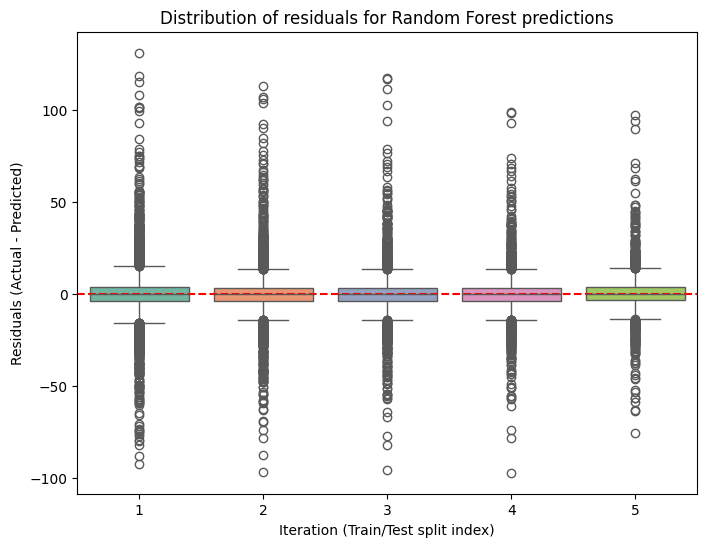

In [73]:
residuals_data = []

for i, (train_frac, test_frac) in enumerate(splits, start=1):
    X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, train_size=train_frac, random_state=RANDOM_STATE)
    rf = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    residuals = Y_test - Y_pred
    for r in residuals:
        residuals_data.append({"Iteration": i, "Residual": r})

residuals_df = pd.DataFrame(residuals_data)

plt.figure(figsize=(8, 6))
sns.boxplot(x="Iteration", y="Residual", data=residuals_df, palette="Set2")
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Iteration (Train/Test split index)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Distribution of residuals for Random Forest predictions")
plt.show()

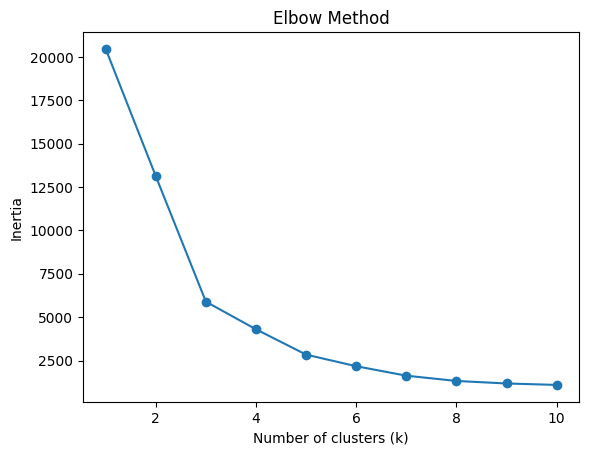

In [86]:
from sklearn.cluster import KMeans

inertia = []
K_range = range(1, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [87]:
km = KMeans(n_clusters=3, random_state=42)
clusters = km.fit_predict(X_scaled)
df['Cluster'] = clusters

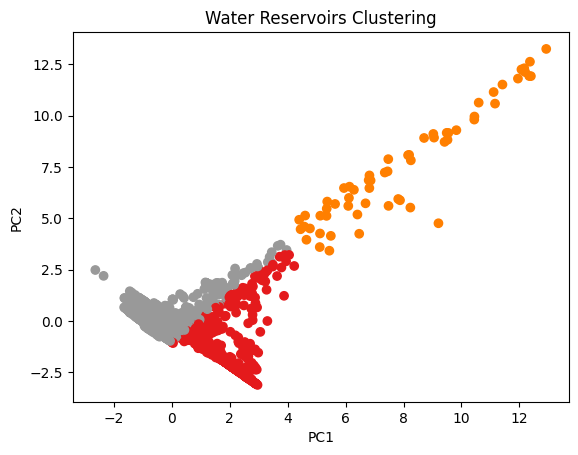

In [88]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='Set1')
plt.title('Water Reservoirs Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [89]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

silhouette = silhouette_score(X_scaled, clusters)
dbi = davies_bouldin_score(X_scaled, clusters)
chi = calinski_harabasz_score(X_scaled, clusters)
inertia=km.inertia_

print("Inertia: ", inertia)
print("Silhouette score: ", silhouette)
print("Davies-Bouldin Index: ", dbi)
print("Calinski-Harabasz Index: ", chi)

Inertia:  5891.028772768247
Silhouette score:  0.6614033652071498
Davies-Bouldin Index:  0.5148257169116376
Calinski-Harabasz Index:  12637.638892069015
